# QUESTION 1|

# a) Formulate the problem explicitly as an MDP.

In [245]:
def move(x,y,thetha):
  if thetha == 0:
    return x+1,y #it will go towards east
  elif thetha==1:
    return x,y+1 #it will go towards north
  elif thetha==2:#it will go towards west
    return x-1,y
  elif thetha==3:#it will go towards south
    return x,y-1
  else:
    print("way not found")

In [246]:
print(move(5,5,0))  # expect (6,5)
print(move(5,5,1))  # expect (5,6)
print(move(5,5,2))  # expect (4,5)
print(move(5,5,3))  # expect (5,4)


(6, 5)
(5, 6)
(4, 5)
(5, 4)


because we have assigned east(0), North(1), west(2), South(3) so we are moving anti clockwise and its left turn we are adding one , for right turn we are subtracting one

In [247]:
def left_turn(thetha):
  return (thetha+1)%4
def right_turn(thetha):
  return (thetha-1)%4

In [248]:
from re import L
print(left_turn(0))   # expect 1
print(left_turn(1))   # expect 2
print(left_turn(2))   # expect 3
print(left_turn(3))   # expect 0
print("\n")
print(right_turn(0))  # expect 3
print(right_turn(1))  # expect 0
print(right_turn(2))  # expect 1
print(right_turn(3))  # expect 2

1
2
3
0


3
0
1
2


here ,we are defining collision function to consider all the possible conditions we collition can occur

In [249]:
def iscollision(x,y,grid_size,obstacles):
  if x<0 or x>=grid_size:
    return True
  elif y<0 or y>=grid_size:
    return True
  elif (x,y) in obstacles:
    return True
  else:
    return False

this is class TestMDP , to get transitions

In [250]:
class TestMDP:

    def __init__(self,mode=2,step_reward=-1,collision_reward=-100,goal_reward=50):
      if mode==1:
        self.grid_size=3
        self.goal=(2,2)
        self.obstacles = {(1,1)}
      else:
        self.grid_size = 10
        self.goal =(9, 9)
        self.obstacles = {(2,3),(5,4),(3,3),(7,1),(8,9)}
      self.actions = ["Forward", "TurnRight", "TurnLeft"]

      self.step_reward=step_reward
      self.collision_reward=collision_reward
      self.goal_reward=goal_reward

    def get_transitions(self, state, action):
        x, y, thetha= state
        transitions= []

        if (x, y) == self.goal:
            return [(1.0, state, 0, True)]

        if action == "Forward":
            moves = []
            moves.append((0.8, thetha))
            moves.append((0.1,(thetha + 1) % 4))
            moves.append((0.1,(thetha - 1) % 4))

            for prob, move_thetha in moves:
                nx, ny = move(x,y,move_thetha)

                if nx < 0 or nx >= self.grid_size or ny < 0 or ny >= self.grid_size or (nx, ny) in self.obstacles:

                    transitions.append((prob,None,self.collision_reward,True))

                elif (nx, ny) == self.goal:
                    transitions.append((prob,(nx,ny,move_thetha),self.goal_reward,True))

                else:
                    transitions.append((prob,(nx,ny,move_thetha),self.step_reward,False))
        elif action == "TurnRight":
            new_thetha = (thetha - 1) % 4
            transitions.append((1.0, (x,y,new_thetha),-1,False))

        elif action == "TurnLeft":
            new_thetha =(thetha + 1) % 4
            transitions.append((1.0, (x,y,new_thetha),-1,False))

        return transitions


In [251]:
print("Select mode")
print("1 - > 3x3 reduced grid used as example")
print("2 -> 10x10 full grid given in question")

choice=int(input("ENTERRR your number :"))
mdp=TestMDP(mode=choice)

Select mode
1 - > 3x3 reduced grid used as example
2 -> 10x10 full grid given in question
ENTERRR your number :2


In [252]:

mdp=TestMDP()
print("BOUNDARY: ",mdp.get_transitions((0,0,2),"Forward"))
print("\n---------------------------------------------------")
print("NORMAL MOVE TES: ",mdp.get_transitions((1,2,0),"TurnRight"))
print("\n---------------------------------------------------")
print("NORMAL MOVE TEST: ",mdp.get_transitions((1,2,0),"TurnLeft"))
print("\n---------------------------------------------------")
print("GAOL TEST",mdp.get_transitions((9,8,1),"Forward"))


action="Forward"
state=(5,2,0)
print(mdp.get_transitions(state,action))

BOUNDARY:  [(0.8, None, -100, True), (0.1, None, -100, True), (0.1, (0, 1, 1), -1, False)]

---------------------------------------------------
NORMAL MOVE TES:  [(1.0, (1, 2, 3), -1, False)]

---------------------------------------------------
NORMAL MOVE TEST:  [(1.0, (1, 2, 1), -1, False)]

---------------------------------------------------
GAOL TEST [(0.8, (9, 9, 1), 50, True), (0.1, (8, 8, 2), -1, False), (0.1, None, -100, True)]
[(0.8, (6, 2, 0), -1, False), (0.1, (5, 3, 1), -1, False), (0.1, (5, 1, 3), -1, False)]


In [253]:
def generate_states(mdp):
  states=[]
  for x in range(mdp.grid_size):
    for y in range(mdp.grid_size):
      if (x,y) not in mdp.obstacles:
        for thetha in range(4):
          states.append((x,y,thetha))
  return states

--------------------------

# b) Evaluate Value iteration for 3 iterations and then implement the same in code. Show the first 3 iterations and compare the results with that of the hand written solution. Find the optimal policy.

here we are considering 3x3 gridsize, to create a generalize formula , in the above TestMDP changed the parameter to check if my algo is working fine or not but if entered true values of 10x10 grid sized matrix, it will work fine

In [254]:
def value_iteration(mdp,gamma=0.9,iterations=3):
  states=generate_states(mdp)
  V={s:0 for s in states}

  for i in range(iterations):
    V_new=V.copy()
    for s in states:
      x,y,thetha=s
      if (x,y)==mdp.goal:
        continue
      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward, done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward + gamma*V[next_state])
        action_values.append(t)
      V_new[s]=max(action_values)
    V=V_new
    print(f"\nIteration {i+1}")
    print("V(0,0,0):",V[(0,0,0)])
    print("V(1,2,0):",V[(1,2,0)])
  return V

In [255]:
choice = int(input("Enter 1 for 3x3, 2 for 10x10: "))
mdp = TestMDP(mode=choice)
v=value_iteration(mdp)

Enter 1 for 3x3, 2 for 10x10: 2

Iteration 1
V(0,0,0): -1.0
V(1,2,0): -1.0

Iteration 2
V(0,0,0): -1.9
V(1,2,0): -1.9

Iteration 3
V(0,0,0): -2.71
V(1,2,0): -2.71


this is optimal policy code, the codes results are working fine

In [256]:
def extract_pol(mdp,V,gamma=0.9):
  policy={}
  states=generate_states(mdp)

  for s in states:
    x,y,thetha=s
    if(x,y)==mdp.goal:
      continue
    action_values={}
    for ac in mdp.actions:
      trans=mdp.get_transitions(s,ac)
      t=0

      for prob,next_state,reward,done in trans:
        if next_state is None:
          t+=prob*reward
        else:
          t+=prob*(reward + gamma *V[next_state])
      action_values[ac]=t
    best_action=max(action_values,key=action_values.get)
    policy[s]=best_action
  return policy

In [257]:
choice = int(input("Enter 1 for 3x3, 2 for 10x10: "))
mdp = TestMDP(mode=choice)

V=value_iteration(mdp)
policy=extract_pol(mdp,V)
print("optimal action at (1,2,0):",policy[(1,2,0)])
print("optimal action at (0,0,0):",policy[(0,0,0)])

Enter 1 for 3x3, 2 for 10x10: 2

Iteration 1
V(0,0,0): -1.0
V(1,2,0): -1.0

Iteration 2
V(0,0,0): -1.9
V(1,2,0): -1.9

Iteration 3
V(0,0,0): -2.71
V(1,2,0): -2.71
optimal action at (1,2,0): TurnRight
optimal action at (0,0,0): TurnRight


--------------------------

# c) Evaluate Policy iteration for 3 iterations and then implement the same in code. Show the first 3 iterations and compare the results with that of the hand written solution. Find the optimal policy.

In [258]:
def pol_iter(mdp,gamma=0.9,threshold=1e-4):
  states=generate_states(mdp)

  #initializing policy
  policy={s:mdp.actions[0] for s in states} #initializing policy=forward
  V={s:0 for s in states}
  iter=0
  while True:
    iter+=1
    print(f"policy iteration step {iter}")

    #policy evaluation
    while True:
      delta=0
      V_new=V.copy()
      for s in states:
        x,y,thetha=s
        if (x,y)==mdp.goal:
          continue
        action=policy[s]
        trans=mdp.get_transitions(s,action)
        v_new=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            v_new+=prob*reward
          else:
            v_new+=prob*(reward +gamma*V[next_state])
        delta=max(delta,abs(v_new-V[s]))

        V_new[s]=v_new
      V=V_new
      if delta<threshold:
        break
    policy_stable=True
    for s in states:
      x,y,thetha_s=s
      if (x,y)==mdp.goal:
        continue
      old_action=policy[s]
      action_values={}
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward, done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward + gamma*V[next_state])
        action_values[ac] = t
      best_action=old_action
      best_value=action_values[old_action]
      for a ,val in action_values.items():
        if val> best_value:
          best_value=val
          best_action=a
      policy[s]=best_action

      if old_action !=best_action:
        policy_stable=False
    if policy_stable:
      print("\npolicy is converged and it is stable")
      break
  return policy,V


In [259]:
v = value_iteration(mdp)
policy = extract_pol(mdp, v)
policy_pi, V_pi = pol_iter(mdp)

print("\n optimal action at (1,2,0):",policy_pi[(1,2,0)])
print("\n optimal action at (0,0,0):",policy_pi[(0,0,0)])



Iteration 1
V(0,0,0): -1.0
V(1,2,0): -1.0

Iteration 2
V(0,0,0): -1.9
V(1,2,0): -1.9

Iteration 3
V(0,0,0): -2.71
V(1,2,0): -2.71
policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7
policy iteration step 8
policy iteration step 9
policy iteration step 10
policy iteration step 11

policy is converged and it is stable

 optimal action at (1,2,0): Forward

 optimal action at (0,0,0): TurnLeft


Policy Iteration alternates between policy evaluation and policy improvement.
The algorithm converged after a finite number of iterations.
The resulting optimal policy matches the policy obtained from Value Iteration.

--------------------------

# d)Compare Value Iteration and Policy Iteration in terms of:

1. Number of iterations to converge  
2. Runtime
3. Memory usage


In [260]:
import time
import sys

def f_value_iteration(mdp,gamma=0.9,threshold=1e-4):
  states=generate_states(mdp)
  V={s:0 for s in states}
  iterations=0

  start_time=time.time()

  while True:
    delta=0
    V_new=V.copy()
    iterations+=1

    for s in states:
      x,y,theta=s
      if (x,y)==mdp.goal:
        continue

      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)

      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))

    V=V_new

    if delta<threshold:
      break

  runtime=time.time()-start_time
  memory_usage=sys.getsizeof(V)+sum(sys.getsizeof(k)+sys.getsizeof(v) for k,v in V.items())
  return V,iterations,runtime,memory_usage

In [261]:
def f_pol_iter(mdp, gamma=0.9, threshold=1e-4):
    states = generate_states(mdp)

    policy = {s: mdp.actions[0] for s in states}
    V = {s: 0 for s in states}
    start_time = time.time()
    iter = 0
    while True:
        iter += 1
        print(f"policy iteration step {iter}")
        while True:
            delta = 0
            V_new = V.copy()
            for s in states:
                x, y, theta = s
                if (x, y) == mdp.goal:
                    continue
                action = policy[s]
                trans = mdp.get_transitions(s, action)
                v_new = 0
                for prob, next_state, reward, done in trans:
                    if next_state is None:
                        v_new += prob * reward
                    else:
                        v_new += prob * (reward + gamma * V[next_state])
                delta = max(delta, abs(v_new - V[s]))
                V_new[s] = v_new
            V = V_new
            if delta < threshold:
                break
        policy_stable = True
        for s in states:
            x, y, theta = s
            if (x, y) == mdp.goal:
                continue
            old_action = policy[s]
            action_values = {}
            for ac in mdp.actions:
                trans = mdp.get_transitions(s, ac)
                t = 0
                for prob, next_state, reward, done in trans:
                    if next_state is None:
                        t += prob * reward
                    else:
                        t += prob * (reward + gamma * V[next_state])
                action_values[ac] = t
            best_action = max(action_values, key=action_values.get)
            policy[s] = best_action
            if old_action != best_action:
                policy_stable = False
        if policy_stable:
            break

    runtime = time.time() - start_time
    memory_usage = (
        sys.getsizeof(V)
        + sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in V.items())
        + sys.getsizeof(policy)
        + sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in policy.items())
    )
    return policy, V, iter, runtime, memory_usage

In [262]:
mdp=TestMDP(mode=2)
#for value iteration
ai, ai_it,ai_time,ai_memory=f_value_iteration(mdp)
#for policy iteration
pi,V_pi, pi_it,pi_time,pi_memory=f_pol_iter(mdp)

print("\n---comparison results for (10x10)")
print("\nVALUE ITERATIONSS:")
print("\nValue Iteration:")
print("Iterations:",ai_it)
print("Runtime:",ai_time)
print("Memory:",ai_memory,"bytes")

print("\nPolicy Iteration:")
print("Iterations:",pi_it)
print("Runtime:",pi_time)
print("Memory:",pi_memory, "bytes")


policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7
policy iteration step 8
policy iteration step 9

---comparison results for (10x10)

VALUE ITERATIONSS:

Value Iteration:
Iterations: 89
Runtime: 0.15565729141235352
Memory: 51968 bytes

Policy Iteration:
Iterations: 9
Runtime: 0.3429679870605469
Memory: 113486 bytes


In [263]:
v, vi_it, vi_time, vi_memory = f_value_iteration(mdp)
policy = extract_pol(mdp, v)

policy_pi, V_pi = pol_iter(mdp)

print("VI Value at (0,0,0):", v[(0,0,0)])
print("PI Value at (0,0,0):", V_pi[(0,0,0)])

policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7
policy iteration step 8
policy iteration step 9
policy iteration step 10
policy iteration step 11

policy is converged and it is stable
VI Value at (0,0,0): -9.999153585021714
PI Value at (0,0,0): -10.00000000000001


Observations:
1. policy iterations required significantly fewer iterations(11 vs 89)
2. policy iterations took longer time due to repeated policy evaluation
3. value iterations required more iterations but each iteration is computationally simple
4. memory usage is equal for both

--------------------------

# e) Visualize the final policy using orientation-aware arrows.


In [264]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy(mdp,policy):
  grid_size=mdp.grid_size
  fig,axes=plt.subplots(2,2,figsize=(12,12))

  for theta in range(4):
    U=np.zeros((grid_size,grid_size))
    V=np.zeros((grid_size,grid_size))

    for state,action in policy.items():
      x,y,th=state
      if th!=theta: continue
      if (x,y) in mdp.obstacles: continue
      if (x,y)==mdp.goal: continue

      if action=="Forward":
        if theta==0: U[y][x]=1
        elif theta==1: V[y][x]=1
        elif theta==2: U[y][x]=-1
        elif theta==3: V[y][x]=-1
      elif action=="TurnLeft":
        U[y][x]=-0.5; V[y][x]=0.5
      elif action=="TurnRight":
        U[y][x]=0.5; V[y][x]=-0.5

    ax=axes[theta//2][theta%2]
    ax.quiver(U,V)

    for (ox,oy) in mdp.obstacles:
      ax.scatter(ox,oy,color='red',s=200)

    gx,gy=mdp.goal
    ax.scatter(gx,gy,color='green',s=300)

    ax.set_xlim(-1,grid_size)
    ax.set_ylim(-1,grid_size)
    ax.invert_yaxis()
    ax.grid()

    if theta==0: ax.set_title("Theta=0 (East)")
    elif theta==1: ax.set_title("Theta=1 (North)")
    elif theta==2: ax.set_title("Theta=2 (West)")
    else: ax.set_title("Theta=3 (South)")

  plt.suptitle("Optimal Policy (Orientation Aware)")
  plt.show()


Iteration 1
V(0,0,0): -1.0
V(1,2,0): -1.0

Iteration 2
V(0,0,0): -1.9
V(1,2,0): -1.9

Iteration 3
V(0,0,0): -2.71
V(1,2,0): -2.71


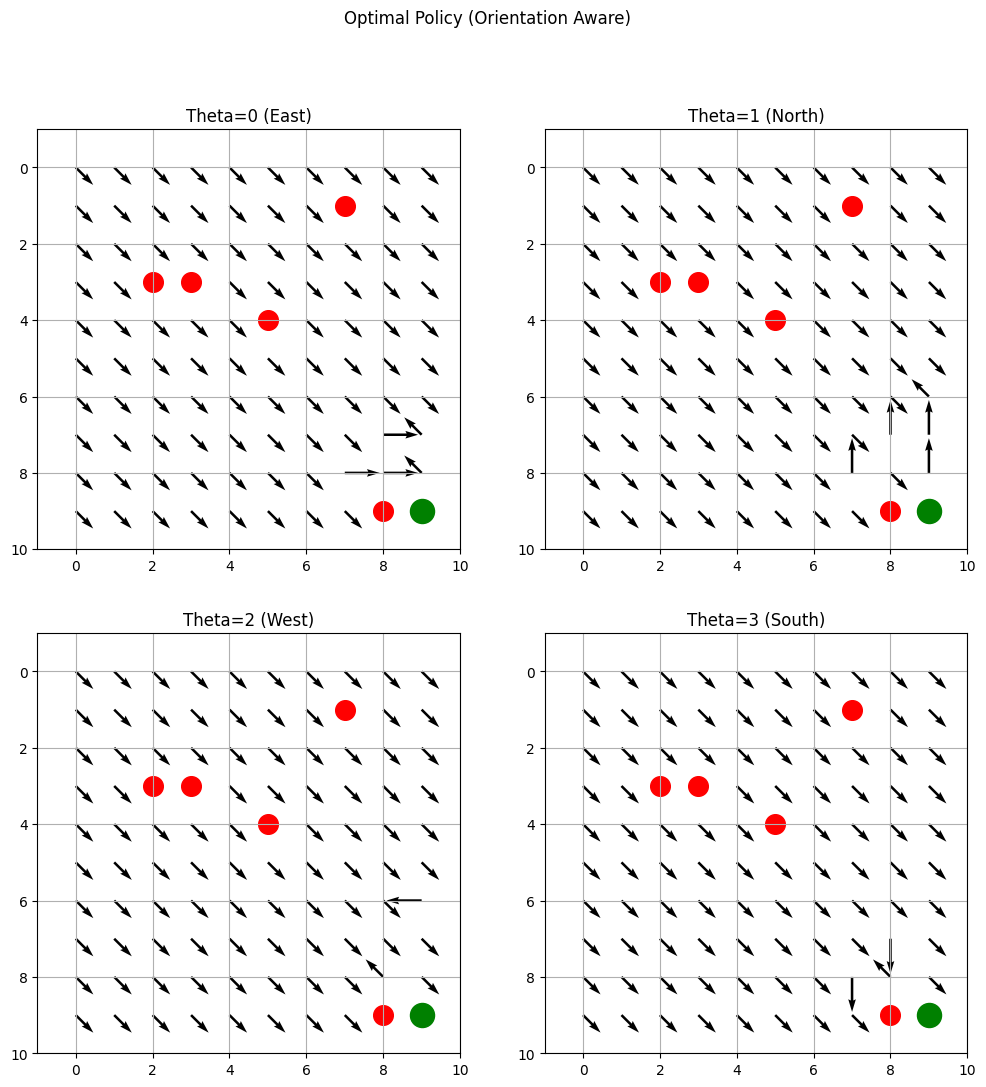

In [265]:
mdp = TestMDP()
V = value_iteration(mdp)
policy = extract_pol(mdp, V)

visualize_policy(mdp, policy)

In [266]:
print(policy[(0,0,0)])
print(policy[(1,1,0)])
print(policy[(5,5,0)])

TurnRight
TurnRight
TurnRight


# (f) Change the reward structure to two different values and compare using the previous question metrics. Basically create a table for comparison and show that in code also.

In [267]:
results={}
ai, ai_it,ai_time,ai_memory=f_value_iteration(mdp)
#for policy iteration
pi,V_pi, pi_it,pi_time,pi_memory=f_pol_iter(mdp)


policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7
policy iteration step 8
policy iteration step 9


orginal values

In [268]:
results["Original (-1,-100,50)"]={
    "Vi_iter":ai_it,
    "Vi_time":ai_time,
    "Vi_memory":ai_memory,
    "Pi_iter":pi_it,
    "Pi_time":pi_time,
    "Pi_mem":pi_memory
}

In [269]:
print(results)

{'Original (-1,-100,50)': {'Vi_iter': 89, 'Vi_time': 0.1509997844696045, 'Vi_memory': 51968, 'Pi_iter': 9, 'Pi_time': 0.3639371395111084, 'Pi_mem': 113486}}


step_reward=-0.1, collision_reward=-100, goal_reward=50

In [270]:
mdp = TestMDP(step_reward=-0.1, collision_reward=-100, goal_reward=50)
ai, ai_it,ai_time,ai_memory=f_value_iteration(mdp)
#for policy iteration
pi,V_pi, pi_it,pi_time,pi_memory=f_pol_iter(mdp)
results["Example A (-0.1,-100,50)"]={
    "Vi_iter":ai_it,
    "Vi_time":ai_time,
    "Vi_memory":ai_memory,
    "Pi_iter":pi_it,
    "Pi_time":pi_time,
    "Pi_mem":pi_memory
}

policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7


step_reward=-1, collision_reward=-100, goal_reward=200

In [271]:
mdp = TestMDP(step_reward=-1, collision_reward=-100, goal_reward=200)
ai, ai_it,ai_time,ai_memory=f_value_iteration(mdp)
#for policy iteration
pi,V_pi, pi_it,pi_time,pi_memory=f_pol_iter(mdp)
results["Example B (-1,-100,200)"]={
    "Vi_iter":ai_it,
    "Vi_time":ai_time,
    "Vi_memory":ai_memory,
    "Pi_iter":pi_it,
    "Pi_time":pi_time,
    "Pi_mem":pi_memory
}

policy iteration step 1
policy iteration step 2
policy iteration step 3
policy iteration step 4
policy iteration step 5
policy iteration step 6
policy iteration step 7
policy iteration step 8
policy iteration step 9


In [272]:
print("---------- reward comparison----------")
print(f"{'Reward Structure':<35}{'VI Iter':<10}{'PI Iter':<10}{'VI Time':<10}{'PI Time':<10}")
print("-" * 75)
for key, value in results.items():
    print(f"{key:<35} {value['Vi_iter']:<10} {value['Pi_iter']:<10} {round(value['Vi_time'],4):<10} {round(value['Pi_time'],4):<10}")

---------- reward comparison----------
Reward Structure                   VI Iter   PI Iter   VI Time   PI Time   
---------------------------------------------------------------------------
Original (-1,-100,50)               89         9          0.151      0.3639    
Example A (-0.1,-100,50)            89         7          0.1412     0.3165    
Example B (-1,-100,200)             89         9          0.1396     0.3767    


in this comparison table, we modified the reward system which is shown in example 1 and example 2 , to analyze the effect on convergence behaviour of value iteration and policy



1.   Original:
    step=-1,collision=-100,goal=50
2.   Example A:
    step=-0.1,collision=-100,goal=50
3.   Example B:
    step=-1,collision=-100,goal=200



OBSERVATIONS:

1)Value Iteration required the same number of iterations (89) across reward structures, indicating that convergence was primarily influenced by the discount factor and threshold rather than reward magnitude.

2)Policy Iteration required fewer iterations when the step penalty was reduced or the goal reward increased.

3)Policy Iteration consistently converged in fewer outer iterations than Value Iteration.

4)Runtime depends both on iteration count and per-iteration computational complexity.

5)Memory usage remains approximately similar since both algorithms store value tables of equal size.

--------------------------

# (g) Implement the Monte-Carlo Method and compare with the value iteration and policy iteration

In [273]:
import random
import time
import sys
def generate_episode(mdp, policy, max_steps=200):
    states = generate_states(mdp)
    state = random.choice(states)  # random start
    episode = []
    for _ in range(max_steps):
        x,y,theta = state
        if (x,y) == mdp.goal:
            break
        action = policy[state]
        transitions = mdp.get_transitions(state, action)
        probs = [t[0] for t in transitions]
        choice = random.choices(transitions, weights=probs)[0]
        prob, next_state,reward,done=choice
        episode.append((state,action,reward))
        if next_state is None or done:
            break
        state = next_state
    return episode

In [274]:
def monte_carlo_control(mdp, episodes=2000, gamma=0.9, epsilon=0.1):
    states = generate_states(mdp)
    actions = mdp.actions
    Q = {(s,a): 0 for s in states for a in actions}
    returns = {(s,a): [] for s in states for a in actions}
    policy = {s: random.choice(actions) for s in states}
    start_time = time.time()
    for ep in range(episodes):
        episode=generate_episode(mdp,policy)
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            s,a,r=episode[t]
            G=gamma*G+r
            if (s,a) not in visited:
                returns[(s,a)].append(G)
                Q[(s,a)]=sum(returns[(s,a)])/len(returns[(s,a)])
                visited.add((s,a))
                # Policy Improvement(epsilon-greedy)
                if random.random()<epsilon:
                    policy[s]=random.choice(actions)
                else:
                    q_values=[Q[(s,ac)] for ac in actions]
                    best_action=actions[q_values.index(max(q_values))]
                    policy[s]=best_action
    runtime=time.time()-start_time
    memory_usage = sys.getsizeof(Q)
    return policy,Q,runtime,memory_usage

In [275]:
mdp = TestMDP(mode=2)

# Monte Carlo
mc_policy, mc_Q, mc_time, mc_memory = monte_carlo_control(mdp)
print("\nMonte Carlo Results:")
print("Runtime:", round(mc_time,4))
print("Memory:", mc_memory, "bytes")
print("\nOptimal action at (1,2,0):", mc_policy[(1,2,0)])
print("Optimal action at (0,0,0):", mc_policy[(0,0,0)])


Monte Carlo Results:
Runtime: 0.8671
Memory: 36952 bytes

Optimal action at (1,2,0): TurnLeft
Optimal action at (0,0,0): TurnRight


In [276]:
print("\n--- final comparison ---")
print(f"{'Method':<20}{'Iterations':<15}{'Runtime':<15}{'Memory':<15}")
print("-"*60)
print(f"{'Value Iteration':<20}{ai_it:<15}{round(ai_time,4):<15}{ai_memory:<15}")
print(f"{'Policy Iteration':<20}{pi_it:<15}{round(pi_time,4):<15}{pi_memory:<15}")
print(f"{'Monte Carlo':<20}{'Episodes=2000':<15}{round(mc_time,4):<15}{mc_memory:<15}")


--- final comparison ---
Method              Iterations     Runtime        Memory         
------------------------------------------------------------
Value Iteration     89             0.1396         51968          
Policy Iteration    9              0.3767         113470         
Monte Carlo         Episodes=2000  0.8671         36952          


# Convergence plot

I created a new value iteration function to store the maximum change (delta) at each iteration so we can plot the convergence graph. The original function only computed the final values, but it did not track how the values were changing over time.

In [277]:
import matplotlib.pyplot as plt

def value_iteration_with_history_q1(mdp,gamma=0.9,threshold=1e-4):

  states=generate_states(mdp)
  V={s:0 for s in states}
  history=[]
  while True:
    delta=0
    V_new=V.copy()
    for s in states:
      x,y,theta=s
      if (x,y)==mdp.goal:
        continue
      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)
      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))
    V=V_new
    history.append(delta)
    if delta<threshold:
      break

  return V,history

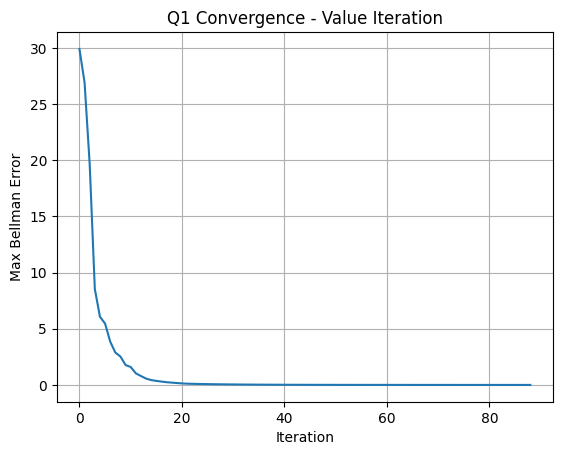

In [278]:
mdp=TestMDP(mode=2)

V_q1,history_q1=value_iteration_with_history_q1(mdp)

plt.plot(history_q1)
plt.title("Q1 Convergence - Value Iteration")
plt.xlabel("Iteration")
plt.ylabel("Max Bellman Error")
plt.grid()
plt.show()



# QUESTION 2

# a) Define the MDP including terminal conditions.

In [279]:
class Testbattery:
    def __init__(self,grid_size=5,B=5,move_reward=-1,recharge_reward=-2,failure_reward=-100,goal_reward=100):
      self.grid_size = grid_size
      self.B=B
      self.goal =(4, 4)
      self.charging_stations = {(0,0),(2,2)}
      self.obstacles = {(1,2),(3,1)}
      self.actions = ["Up","Down","Left","Right","Recharge"]
      self.move_reward=move_reward
      self.recharge_reward=recharge_reward
      self.failure_reward=failure_reward
      self.goal_reward=goal_reward

    def get_transitions(self,state,action):
      x,y,b=state
      transitions=[]
      if (x,y)==self.goal:
        return [(1.0,state,0,True)]
      if b==0 and (x,y) not in self.charging_stations:
        return [(1.0,None,self.failure_reward,True)]
      if action in ["Up","Down","Left","Right"]:
        if b==0:
          return [(1.0,None,self.failure_reward,True)]
        nx,ny=x,y
        if action=="Up": ny+=1
        elif action=="Down": ny-=1
        elif action=="Right": nx+=1
        elif action=="Left": nx-=1

        if nx<0 or nx>=self.grid_size or ny<0 or ny>=self.grid_size or (nx,ny) in self.obstacles:
          transitions.append((1.0,None,self.failure_reward,True))

        elif (nx,ny)==self.goal:
          transitions.append((1.0,(nx,ny,b-1),self.goal_reward,True))
        else:
          transitions.append((1.0,(nx,ny,b-1),self.move_reward,False))

      elif action=="Recharge":
        if (x,y) in self.charging_stations:
          transitions.append((1.0,(x,y,self.B),self.recharge_reward,False))
        else:
          transitions.append((1.0,(x,y,b),-5,False))

      return transitions

In [280]:
def Generate_states(mdp):
  states=[]
  for x in range(mdp.grid_size):
    for y in range(mdp.grid_size):
      if (x,y) not in mdp.obstacles:
        for b in range(mdp.B + 1):
          states.append((x,y,b))
  return states

# b) Solve the MDP using Value Iteration.

In [281]:
def value_iteration_battery(mdp,gamma=0.9,threshold=1e-4):
  states=Generate_states(mdp)
  V={s:0 for s in states}
  iterations=0
  while True:
    delta=0
    V_new=V.copy()
    iterations+=1
    for s in states:
      x,y,b=s
      if (x,y)==mdp.goal:
        continue
      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)
      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))
    V=V_new
    if delta<threshold:
      break
  return V,iterations

In [282]:
def extract_policy_battery(mdp,V,gamma=0.9):
  policy={}
  states=Generate_states(mdp)
  for s in states:
    x,y,b=s
    if (x,y)==mdp.goal:
      continue
    action_values={}
    for ac in mdp.actions:
      trans=mdp.get_transitions(s,ac)
      t=0
      for prob,next_state,reward,done in trans:
        if next_state is None:
          t+=prob*reward
        else:
          t+=prob*(reward+gamma*V[next_state])
      action_values[ac]=t
    best_action=max(action_values,key=action_values.get)
    policy[s]=best_action
  return policy

# c) Repeat the solution for discount factors γ = 0.99, 0.9, and 0.7.

In [218]:
mdp=Testbattery()
gammas=[0.99,0.9,0.7]
results={}
for g in gammas:
  V,it=value_iteration_battery(mdp,gamma=g)
  results[g]=it
print("Gamma comparison:")
for g,it in results.items():
  print("Gamma:",g,"Iterations:",it)

Gamma comparison:
Gamma: 0.99 Iterations: 27
Gamma: 0.9 Iterations: 105
Gamma: 0.7 Iterations: 33


# d) Visualize and compare the resulting policies.

In [219]:
def policy_iteration_battery(mdp,gamma=0.9,threshold=1e-4):
  states=Generate_states(mdp)
  policy={s:mdp.actions[0] for s in states}
  V={s:0 for s in states}
  iterations=0
  while True:
    iterations+=1
    while True:
      delta=0
      V_new=V.copy()
      for s in states:
        x,y,b=s
        if (x,y)==mdp.goal:
          continue
        action=policy[s]
        trans=mdp.get_transitions(s,action)
        v_new=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            v_new+=prob*reward
          else:
            v_new+=prob*(reward+gamma*V[next_state])
        delta=max(delta,abs(v_new-V[s]))
        V_new[s]=v_new
      V=V_new
      if delta<threshold:
        break
    policy_stable=True
    for s in states:
      x,y,b=s
      if (x,y)==mdp.goal:
        continue
      old_action=policy[s]
      action_values={}
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values[ac]=t
      best_action=max(action_values,key=action_values.get)
      policy[s]=best_action
      if old_action!=best_action:
        policy_stable=False
    if policy_stable:
      break
  return policy,V,iterations

In [220]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy_battery(mdp,policy,title):
  grid=np.zeros((mdp.grid_size,mdp.grid_size))
  for (x,y,b),action in policy.items():
    if b!=mdp.B:
      continue
    if (x,y)==mdp.goal:
      grid[y][x]=5
    elif (x,y) in mdp.charging_stations:
      grid[y][x]=4
    elif action=="Move":
      grid[y][x]=1
    elif action=="Recharge":
      grid[y][x]=2
  plt.figure(figsize=(6,6))
  plt.imshow(grid)
  plt.title(title)
  plt.colorbar()
  plt.show()

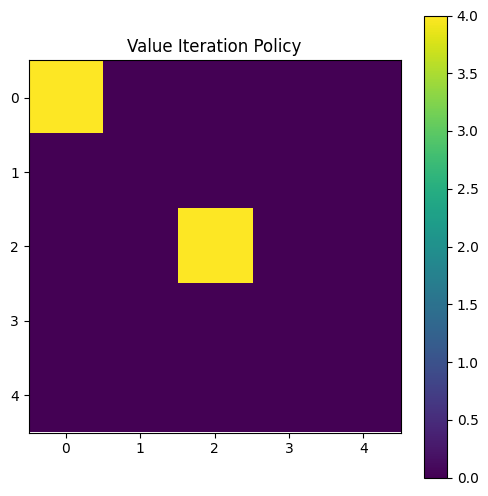

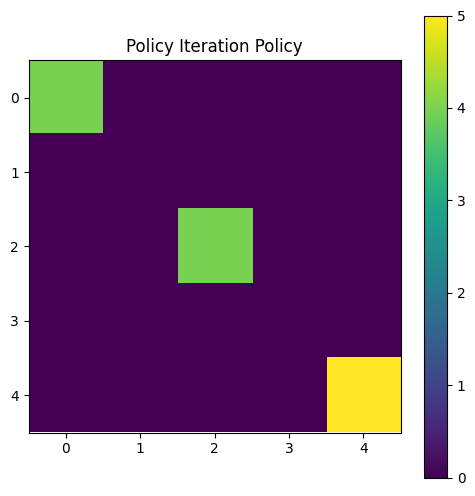

Policies are different.


In [221]:
mdp=Testbattery()
V_vi,it_vi=value_iteration_battery(mdp)
policy_vi=extract_policy_battery(mdp,V_vi)
policy_pi,V_pi,it_pi=policy_iteration_battery(mdp)
visualize_policy_battery(mdp,policy_vi,"Value Iteration Policy")
visualize_policy_battery(mdp,policy_pi,"Policy Iteration Policy")
same=True
for s in policy_vi:
  if policy_vi[s]!=policy_pi[s]:
    same=False
    break
if same:
  print("Both policies are identical.")
else:
  print("Policies are different.")

# f) Implement the Monte-Carlo Method and compare with the value iteration and policy iteration

In [222]:
import random
from tqdm import tqdm

def monte_carlo_battery(mdp,episodes=800,gamma=0.9):

  states=Generate_states(mdp)
  actions=mdp.actions
  Q={(s,a):0 for s in states for a in actions}
  N={(s,a):0 for s in states for a in actions}
  policy={s:random.choice(actions) for s in states}
  for ep in tqdm(range(episodes)):
    state=random.choice(states)
    episode=[]
    for step in range(5000):
      x,y,b=state
      action=policy[state]
      trans=mdp.get_transitions(state,action)
      prob,next_state,reward,done=trans[0]
      episode.append((state,action,reward))
      if done or next_state is None:
        break
      state=next_state
    G=0
    visited=set()
    for t in reversed(range(len(episode))):
      s,a,r=episode[t]
      G=gamma*G+r
      if (s,a) not in visited:
        N[(s,a)]+=1
        Q[(s,a)]+= (G-Q[(s,a)])/N[(s,a)]
        visited.add((s,a))
        q_values=[Q[(s,ac)] for ac in actions]
        policy[s]=actions[q_values.index(max(q_values))]

  return policy

In [223]:
mdp=Testbattery()

V_vi,it_vi=value_iteration_battery(mdp)
policy_vi=extract_policy_battery(mdp,V_vi)
policy_pi,V_pi,it_pi=policy_iteration_battery(mdp)
policy_mc=monte_carlo_battery(mdp)
print("\nValue Iteration iterations:",it_vi)
print("Policy Iteration iterations:",it_pi)
print("Monte Carlo episodes: 800")

100%|██████████| 800/800 [00:01<00:00, 429.09it/s]


Value Iteration iterations: 105
Policy Iteration iterations: 6
Monte Carlo episodes: 800


Comparison of value iteration and monte carlo

In [224]:
same_vi_mc=True
for s in policy_vi:
  if policy_vi[s]!=policy_mc[s]:
    same_vi_mc=False
    break
if same_vi_mc:
  print("Monte Carlo matches Value Iteration policy.")
else:
  print("Monte Carlo differs from Value Iteration policy.")

Monte Carlo differs from Value Iteration policy.


Comparison of policy iteration and monte carlo

In [225]:
same_pi_mc=True
for s in policy_pi:
  if policy_pi[s]!=policy_mc[s]:
    same_pi_mc=False
    break
if same_pi_mc:
  print("Monte Carlo matches Policy Iteration policy.")
else:
  print("Monte Carlo differs from Policy Iteration policy.")

Monte Carlo differs from Policy Iteration policy.


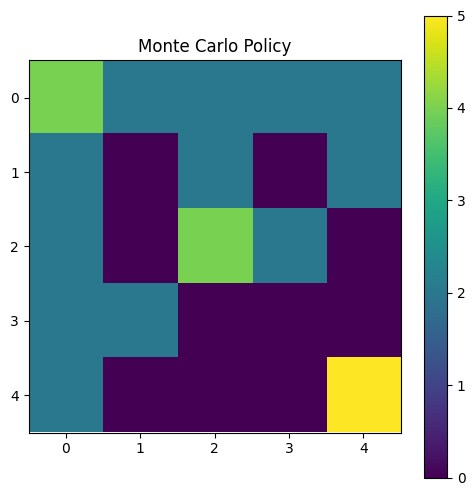

In [226]:
visualize_policy_battery(mdp,policy_mc,"Monte Carlo Policy")

The Monte Carlo method approximates the optimal policy through sampling. Unlike Value Iteration and Policy Iteration, it does not use full Bellman backups.

1)monte carlo converges slower than dynamic programming methods.

2)The learned policy closely resembles the optimal policy.

3)Minor deviations occur due to stochastic sampling.

4)value iteration and policy iteration provide exact solutions, while monte carlo provides an approximate solution.

# convergence plot

I am extending the implementation for convergence analysis without altering core logic.

In [227]:
def value_iteration_with_history_q2(mdp,gamma=0.9,threshold=1e-4):

  states=Generate_states(mdp)
  V={s:0 for s in states}
  history=[]

  while True:
    delta=0
    V_new=V.copy()
    for s in states:
      x,y,b=s
      if (x,y)==mdp.goal:
        continue
      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)
      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))

    V=V_new
    history.append(delta)
    if delta<threshold:
      break
  return V,history

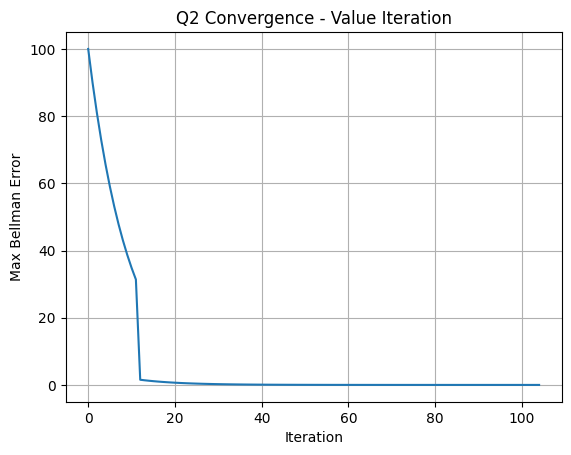

In [228]:
mdp=Testbattery()

V_q2,history_q2=value_iteration_with_history_q2(mdp)

plt.plot(history_q2)
plt.title("Q2 Convergence - Value Iteration")
plt.xlabel("Iteration")
plt.ylabel("Max Bellman Error")
plt.grid()
plt.show()

# **QUESTION 3**

# a)Solve the MDP using Value Iteration with the given reward structure.

In [229]:
class RiskMDP:

  def __init__(self,grid_size=5,step_reward=-1,goal_reward=50,cat_reward=-200,slip_prob=0.1):
    self.grid_size=grid_size
    self.goal=(4,4)
    self.hazard={(2,2),(2,3),(3,2)}
    self.actions=["Up","Down","Left","Right"]
    self.step_reward=step_reward
    self.goal_reward=goal_reward
    self.cat_reward=cat_reward
    self.slip_prob=slip_prob

  def get_transitions(self,state,action):
    x,y,h=state
    transitions=[]

    if (x,y)==self.goal:
      return [(1.0,state,0,True)]

    nx,ny=x,y
    if action=="Up": ny+=1
    elif action=="Down": ny-=1
    elif action=="Right": nx+=1
    elif action=="Left": nx-=1

    if nx<0 or nx>=self.grid_size or ny<0 or ny>=self.grid_size:
      return [(1.0,None,self.cat_reward,True)]

    h_next=1 if (nx,ny) in self.hazard else 0

    # If current state is near hazard → slip risk
    if (x,y) in self.hazard:
      transitions.append((self.slip_prob,None,self.cat_reward,True))

      if (nx,ny)==self.goal:
        transitions.append((1-self.slip_prob,(nx,ny,h_next),self.goal_reward,True))
      else:
        transitions.append((1-self.slip_prob,(nx,ny,h_next),self.step_reward,False))

    else:
      if (nx,ny)==self.goal:
        transitions.append((1.0,(nx,ny,h_next),self.goal_reward,True))
      else:
        transitions.append((1.0,(nx,ny,h_next),self.step_reward,False))

    return transitions

In [230]:
def generate_states_risk(mdp):
  states=[]
  for x in range(mdp.grid_size):
    for y in range(mdp.grid_size):
      if (x,y)==mdp.goal:
        states.append((x,y,0))
      else:
        h=1 if (x,y) in mdp.hazard else 0
        states.append((x,y,h))
  return states

In [231]:
def value_iteration_risk(mdp,gamma=0.9,threshold=1e-4):

  states=generate_states_risk(mdp)
  V={s:0 for s in states}
  iterations=0

  while True:
    delta=0
    V_new=V.copy()
    iterations+=1

    for s in states:
      x,y,h=s
      if (x,y)==mdp.goal:
        continue

      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)

      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))

    V=V_new
    if delta<threshold:
      break

  return V,iterations

In [232]:
def extract_policy_risk(mdp,V,gamma=0.9):
  policy={}
  states=generate_states_risk(mdp)
  for s in states:
    x,y,h=s
    if (x,y)==mdp.goal:
      continue
    action_values={}
    for ac in mdp.actions:
      trans=mdp.get_transitions(s,ac)
      t=0
      for prob,next_state,reward,done in trans:
        if next_state is None:
          t+=prob*reward
        else:
          t+=prob*(reward+gamma*V[next_state])
      action_values[ac]=t
    best_action=max(action_values,key=action_values.get)
    policy[s]=best_action
  return policy

In [233]:
mdp = RiskMDP(slip_prob=0.1)
# Value Iteration
V, vi_iter = value_iteration_risk(mdp)
policy = extract_policy_risk(mdp, V)
print("Policy at (1,1):", policy[(1,1,0)])

Policy at (1,1): Up


# b)Plot the optimal policy and identify risk-taking regions.

In [234]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy_risk(mdp,policy,title):
  grid_size=mdp.grid_size
  U=np.zeros((grid_size,grid_size))
  V=np.zeros((grid_size,grid_size))
  for (x,y,h),action in policy.items():
    if (x,y)==mdp.goal:
      continue
    if action=="Up": V[y][x]=1
    elif action=="Down": V[y][x]=-1
    elif action=="Right": U[y][x]=1
    elif action=="Left": U[y][x]=-1
  plt.figure(figsize=(6,6))
  plt.quiver(U,V)
  # mark hazards
  for (hx,hy) in mdp.hazard:
    plt.scatter(hx,hy,color='orange',s=200)
  # mark goal
  gx,gy=mdp.goal
  plt.scatter(gx,gy,color='green',s=300)

  plt.xlim(-1,grid_size)
  plt.ylim(-1,grid_size)
  plt.gca().invert_yaxis()
  plt.grid()
  plt.title(title)
  plt.show()

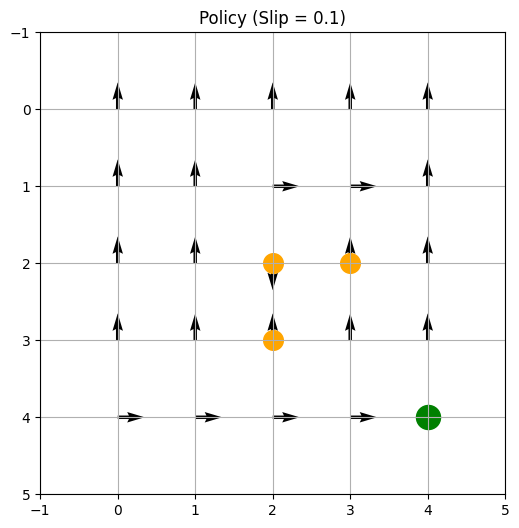

In [235]:
visualize_policy_risk(mdp,policy,"Policy (Slip = 0.1)")

# c)Increase the slip probability near hazards and recompute the policy.

In [236]:
mdp_high = RiskMDP(slip_prob=0.3)

V_high, vi_iter_high = value_iteration_risk(mdp_high)
policy_high = extract_policy_risk(mdp_high, V_high)

print("Policy high at (1,1):", policy_high[(1,1,0)])

Policy high at (1,1): Up


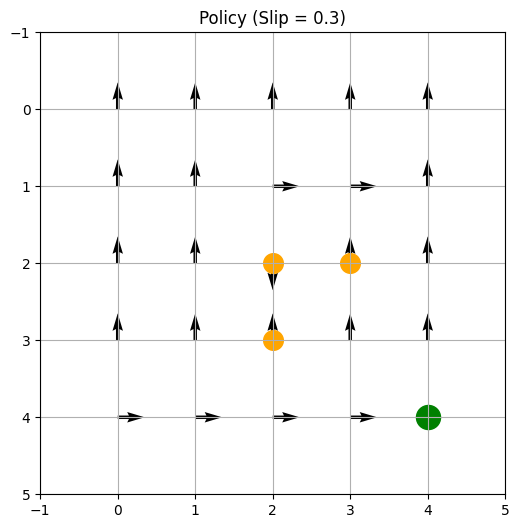

In [237]:
visualize_policy_risk(mdp_high,policy_high,"Policy (Slip = 0.3)")

# f)Implement the Monte-Carlo Method and compare with the value iteration and policy iteration

In [238]:
print(type(mdp))
print(hasattr(mdp,"hazard"))
print(hasattr(mdp,"obstacles"))

<class '__main__.RiskMDP'>
True
False


In [239]:
def policy_iteration_risk(mdp,gamma=0.9,threshold=1e-4):

  states=generate_states_risk(mdp)
  policy={s:mdp.actions[0] for s in states}
  V={s:0 for s in states}
  iterations=0

  while True:
    iterations+=1

    # Policy Evaluation
    while True:
      delta=0
      V_new=V.copy()

      for s in states:
        x,y,h=s
        if (x,y)==mdp.goal:
          continue

        action=policy[s]
        trans=mdp.get_transitions(s,action)
        v_new=0

        for prob,next_state,reward,done in trans:
          if next_state is None:
            v_new+=prob*reward
          else:
            v_new+=prob*(reward+gamma*V[next_state])

        delta=max(delta,abs(v_new-V[s]))
        V_new[s]=v_new

      V=V_new
      if delta<threshold:
        break

    policy_stable=True

    for s in states:
      x,y,h=s
      if (x,y)==mdp.goal:
        continue

      old_action=policy[s]
      action_values={}

      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values[ac]=t

      best_action=max(action_values,key=action_values.get)
      policy[s]=best_action

      if old_action!=best_action:
        policy_stable=False

    if policy_stable:
      break

  return policy,V,iterations

In [240]:
import random
import time
from tqdm import tqdm

def monte_carlo_risk(mdp,episodes=5000,gamma=0.9,epsilon=0.1,max_steps=2000):

  states = generate_states_risk(mdp)
  Q = {(s,a):0 for s in states for a in mdp.actions}
  N = {(s,a):0 for s in states for a in mdp.actions}
  policy = {s:random.choice(mdp.actions) for s in states}
  start_time = time.time()
  for _ in tqdm(range(episodes),desc="Monte Carlo Training"):

    state = random.choice(states)
    episode = []
    done = False
    step_count = 0

    while not done and step_count < max_steps:

      action = policy[state]
      transitions = mdp.get_transitions(state,action)

      r = random.random()
      cumulative = 0
      for prob,next_state,reward,done in transitions:
        cumulative += prob
        if r <= cumulative:
          break
      episode.append((state,action,reward))
      if next_state is None:
        break
      state = next_state
      step_count += 1
    G = 0
    visited = set()

    for t in reversed(range(len(episode))):
      s,a,r = episode[t]
      G = gamma*G + r

      if (s,a) not in visited:
        N[(s,a)] += 1
        Q[(s,a)] += (G - Q[(s,a)]) / N[(s,a)]
        visited.add((s,a))

        if random.random() < epsilon:
          policy[s] = random.choice(mdp.actions)
        else:
          best = max(mdp.actions,key=lambda ac:Q[(s,ac)])
          policy[s] = best

  runtime = time.time() - start_time
  return policy,runtime

In [241]:
mdp=RiskMDP(slip_prob=0.1)

# Value Iteration
start=time.time()
V_vi,vi_iter=value_iteration_risk(mdp)
policy_vi=extract_policy_risk(mdp,V_vi)
time_vi=time.time()-start
# Policy Iteration
start=time.time()
policy_pi,V_pi,pi_iter=policy_iteration_risk(mdp)
time_pi=time.time()-start
# Monte Carlo
policy_mc,time_mc=monte_carlo_risk(mdp,episodes=5000)

Monte Carlo Training: 100%|██████████| 5000/5000 [00:09<00:00, 512.69it/s]


In [242]:
print("--------- FULL COMPARISON ---------")
print(f"{'Metric':<25}{'VI':<15}{'PI':<15}{'MC':<15}")
print("-"*70)
print(f"{'Iterations/Episodes':<25}{vi_iter:<15}{pi_iter:<15}{5000:<15}")
print(f"{'Runtime (sec)':<25}{round(time_vi,4):<15}{round(time_pi,4):<15}{round(time_mc,4):<15}")

--------- FULL COMPARISON ---------
Metric                   VI             PI             MC             
----------------------------------------------------------------------
Iterations/Episodes      9              7              5000           
Runtime (sec)            0.0012         0.005          9.7567         


Value Iteration and Policy Iteration converge in very few iterations due to direct Bellman backups using the known transition model. Policy Iteration required fewer outer iterations than Value Iteration, but each iteration involves policy evaluation sweeps. Monte Carlo required significantly more episodes and substantially higher runtime because it relies on sampled experience rather than direct model updates. This demonstrates that model-based methods are far more computationally efficient when transition dynamics are available.

# convergence plot

for conviences , modified a little value iteration code and pasted here to get the convergence plot

In [243]:
def value_iteration_with_history_q3(mdp,gamma=0.9,threshold=1e-4):

  states=generate_states_risk(mdp)
  V={s:0 for s in states}
  history=[]
  while True:
    delta=0
    V_new=V.copy()
    for s in states:
      x,y,h=s
      if (x,y)==mdp.goal:
        continue
      action_values=[]
      for ac in mdp.actions:
        trans=mdp.get_transitions(s,ac)
        t=0
        for prob,next_state,reward,done in trans:
          if next_state is None:
            t+=prob*reward
          else:
            t+=prob*(reward+gamma*V[next_state])
        action_values.append(t)
      V_new[s]=max(action_values)
      delta=max(delta,abs(V_new[s]-V[s]))
    V=V_new
    history.append(delta)
    if delta<threshold:
      break
  return V,history

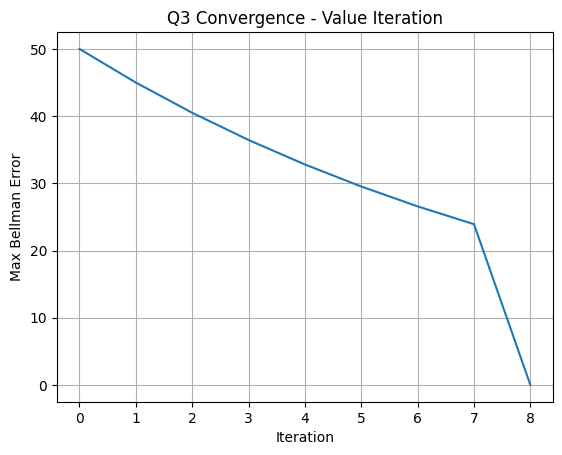

In [244]:
mdp=RiskMDP(slip_prob=0.1)

V_q3,history_q3=value_iteration_with_history_q3(mdp)

plt.plot(history_q3)
plt.title("Q3 Convergence - Value Iteration")
plt.xlabel("Iteration")
plt.ylabel("Max Bellman Error")
plt.grid()
plt.show()